In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from ctapipe.io import read_table
from ctapipe.visualization import CameraDisplay
from ctapipe_io_lst import load_camera_geometry
from ctapipe.coordinates import EngineeringCameraFrame

from ctapipe.io.hdf5tableio import HDF5TableReader

# camera monitoring containers
from ctapipe.containers import (
    FlatFieldContainer,
    WaveformCalibrationContainer,
    PedestalContainer,
    PixelStatusContainer,
)

# HG=0 LG=1
channel=["HG","LG"]

<font size="4">Read the calibration file of data 20210915 : <br>
<ul>    
<li> data in  [data_tree_base_dir]/real/monitoring/PixelCalibration/LevelA/calibration/20210915/pro/calibration_filters_52.Run06317.0000.h5    
<li> you can check the control plots in [data_tree_base_dir]/real/monitoring/PixelCalibration/LevelA/calibration/20210915/pro/log/calibration_filters_52.Run06317.0000.pdf
</ul>    
</font>


In [12]:
# change the file name with one of your data tree
file_name="/fefs/aswg/data/real/monitoring/PixelCalibration/LevelA/calibration/20210915/pro/calibration_filters_52.Run06317.0000.h5"
tel_id=1 

# declare the monitoring containers
ff_data = FlatFieldContainer()
ped_data = PedestalContainer()
calib_data = WaveformCalibrationContainer()
status_data = PixelStatusContainer()

# read the file
with HDF5TableReader(file_name) as h5_table:
    assert h5_table._h5file.isopen == True

    table = f"/tel_{tel_id}/flatfield"
    next(h5_table.read(table, ff_data))
    table = f"/tel_{tel_id}/calibration"
    next(h5_table.read(table, calib_data))
    table = f"/tel_{tel_id}/pedestal"
    next(h5_table.read(table, ped_data))
    table = f"/tel_{tel_id}/pixel_status"
    next(h5_table.read(table, status_data))


In [45]:
# calibration data container
calib_data

ctapipe.containers.WaveformCalibrationContainer:
                          time: Time associated to the calibration event [s]
                      time_min: Earliest time of validity for the calibration
                                event [s]
                      time_max: Latest time of validity for the calibration
                                event [s]
                      dc_to_pe: np array of (digital count) to (photon electron)
                                coefficients (n_chan, n_pix)
           pedestal_per_sample: np array of average pedestal value per sample
                                (digital count) (n_chan, n_pix)
               time_correction: np array of time correction values (n_chan,
                                n_pix)
                          n_pe: np array of photo-electrons in calibration
                                signal (n_chan, n_pix)
               unusable_pixels: Boolean np array of final calibration data
                                

<font size="5">Exercises  1: <br>
   
<font size="4">Plot the distribution of the number of FF photon-electrons over the camera. Highlight the defective pixels stored in the array calib_data.unusable_pixels


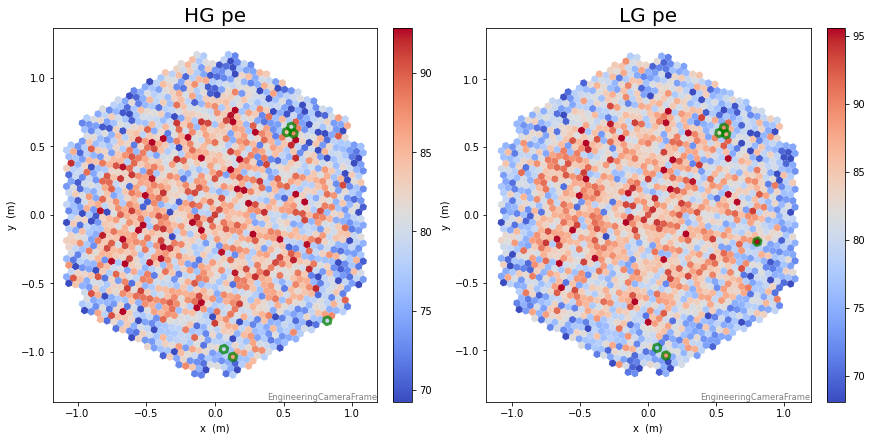

In [17]:
# plot ff events median charge over the camera for the two channels

# read camera geometry
camera = load_camera_geometry().transform_to(EngineeringCameraFrame())

fig, ax = plt.subplots(1, 2, figsize=(12,6),constrained_layout=True)
  
image = calib_data.n_pe

# ge the median charge outliers : pixels with values > x sigma from median camera value
mask = calib_data.unusable_pixels

for chan in np.arange(2):
    disp = CameraDisplay(camera,ax=ax[chan])
    mymin = np.median(image[chan]) - 2 * np.std(image[chan])
    mymax = np.median(image[chan]) + 2 * np.std(image[chan])
    disp.set_limits_minmax(mymin, mymax)
    disp.highlight_pixels(mask[chan], linewidth=3)
    disp.image = image[chan]
    disp.cmap = plt.cm.coolwarm
    ax[chan].set_title(f"{channel[chan]} pe", fontsize=20)
    disp.add_colorbar()
 

<font size="5">Exercises 2 : <br>

<font size="4">  Plot the histograms of the pixel gain (=1/dc_to_pe) for the two channels. Use the calib_data.unusable_pixels array to mask defective pixels
   


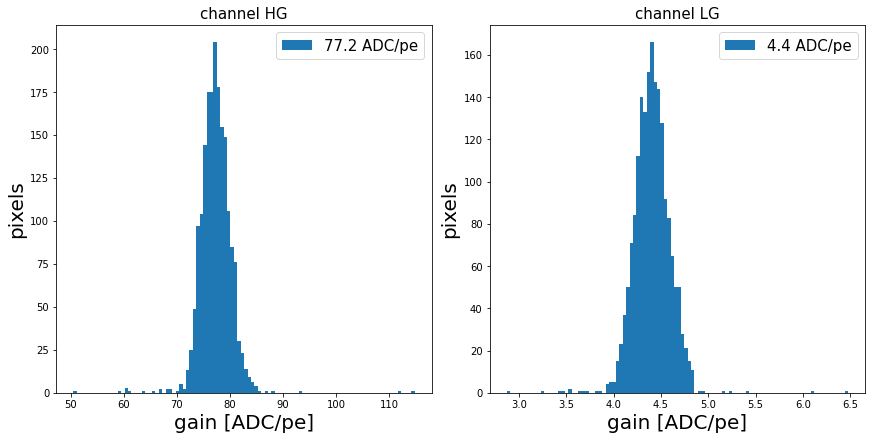

In [20]:
# plot gains for the two channels
fig, ax = plt.subplots(1, 2, figsize=(12,6),constrained_layout=True)
for chan in np.arange(2):
    ax[chan].set_title(f"channel {channel[chan]}",fontsize=15)
    mask=calib_data.unusable_pixels[chan]
    gain=1./calib_data.dc_to_pe[chan][~mask]
    label=f"{np.median(gain):3.1f} ADC/pe"
    ax[chan].hist(gain, bins=100,label=label)
    ax[chan].set_ylabel(f'pixels',fontsize=20) 
    ax[chan].set_xlabel(f'gain [ADC/pe]',fontsize=20) 
   
    ax[chan].legend(prop={'size':15})